# Training an ANN to represent the gravity produced by a mascon
In this notebook we explore the possibility to use ANNs to represent the generic shape and density of an irregular body represented by a mascon model. The error is defined on the gravitational potential field.

A mascon model is a tuple (points, masses, name) containing the x,y,z position of N points in the unit cube and their masses and the name of the mascon.

To run this notebook (and the others) create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib jupyter pytorch
 conda activate geodesyann
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
```


In [2]:
# core stuff
import gravann
import numpy as np
import pickle as pk

# pytorch
from torch import nn
import torch
# For debugging and development purposes this is now set to float64 ... change for speed on GPUs
torch.set_default_tensor_type(torch.DoubleTensor)

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Loading and visualizing the ground truth asteroid (a point cloud)

In [3]:
with open("mascons/Eros.pk", "rb") as file:
    points, masses, name = pk.load(file)
    
points = torch.tensor(points)
masses = torch.tensor(masses)

print("Name: ", name)
print("Number of points: ", len(points))
print("Total mass: ", sum(masses))

Name:  Eros
Number of points:  2691
Total mass:  tensor(1.0000)


<IPython.core.display.Javascript object>


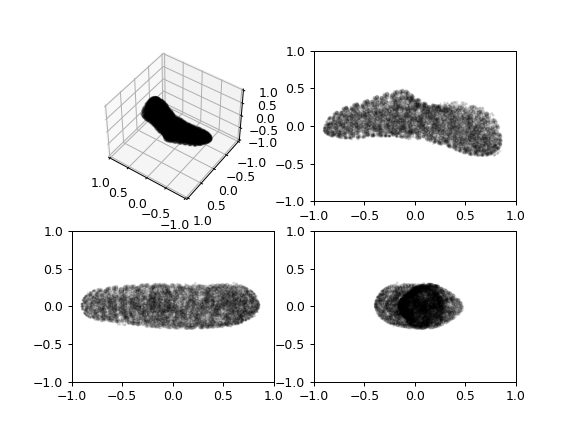

In [4]:
gravann.plot_mascon(points, masses)

# Representing an asteroid via a neural network


## 1 - Instantiating the network
The networks inputs are the cartesian coordinates of a point in the unit cube, encoded via some transformation

In [5]:
# Encoding choosen
encoding = gravann.direct_encoding()

# Network initialization scheme (note that if xavier uniform is used all outputs will start at, roughly 0.5)
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.uniform_(m.bias.data, -0.0, 0.0)

# Network architecture. Note that the dimensionality of the first linear layer must match the output
# of the encoding chosen
n_neurons = 100
model = nn.Sequential(
          nn.Linear(encoding.dim,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,1),
          nn.Sigmoid(),
        )

# Applying our weight initialization
_  = model.apply(weights_init)

In [6]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
#model.load_state_dict(torch.load("models/" + name + "_" + encoding.name + ".mdl"))

## Visualizing an asteroid represented by the network
The network output is the density in the unit cube. It is, essentially, a three dimensional function and as such it is difficult to plot. 

### Approach 1: plotting a grid of points colored with the rho value

<IPython.core.display.Javascript object>


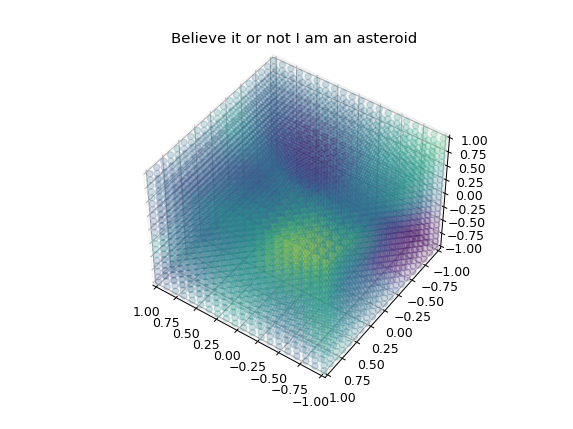

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [7]:
gravann.plot_model_grid(model, encoding, views_2d=False)
plt.title("Believe it or not I am an asteroid")

### Approach 2: considering rho as a probability density function and sampling points from it

<IPython.core.display.Javascript object>


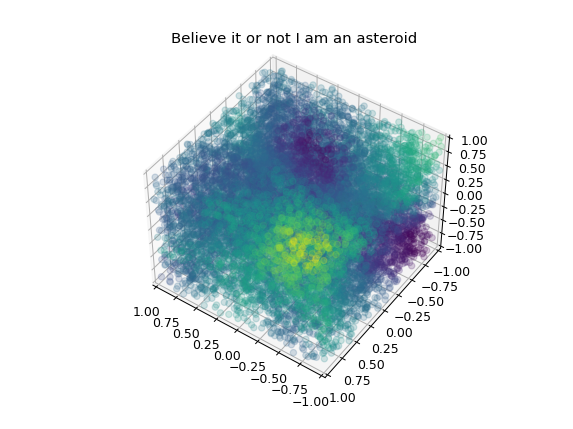

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [8]:
gravann.plot_model_rejection(model, encoding, views_2d=False)
plt.title("Believe it or not I am an asteroid")

# Training The ANN to match the ground truth potential

Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [9]:
# Here we set the loss
loss_fn = gravann.normalized_loss

# Here we set the choosen Monte Carlo method
mc_method = gravann.U_Pld

# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
# This is the main training loop
for i in range(5000):
    # At each new epoch we generate new points (its like a new batch), but we make sure
    # they are outside the unit cube
    targets = (torch.rand(100,3)*2-1)*1.1
    a = torch.logical_and((targets[:,0]>-1),(targets[:,0]<1))
    b = torch.logical_and((targets[:,1]>-1),(targets[:,1]<1))
    c = torch.logical_and((targets[:,2]>-1),(targets[:,2]<1))
    d = torch.logical_and(torch.logical_or(a,b), c)
    targets=targets[d]
    labels = gravann.U_L(targets, points, masses)
    
    # Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
    predicted = mc_method(targets, model, encoding, N=200000)
    loss = loss_fn(predicted, labels)
    print(i, loss.item())
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 0.00010730841826973152
1 8.732559556155048e-05
2 3.101295851025048e-05
3 1.7081068629621163e-05
4 3.659030590854304e-05
5 9.053184200075451e-05
6 8.401461203067592e-05
7 1.6572290400070805e-05
8 2.4844093415285837e-05
9 3.810458886256104e-05
10 3.160748411721149e-05
11 2.4572458575368448e-05
12 1.6509598910396893e-05
13 7.226865881086099e-05
14 3.8242971888211244e-05
15 4.1044959594913684e-05
16 7.880123725444856e-06
17 2.9280828873359164e-05
18 3.5269094084077806e-05
19 6.967048989313546e-05
20 5.327420821459907e-05
21 2.119277002706629e-05
22 3.75331769707565e-05
23 4.049944683639624e-05
24 8.845375601946578e-05
25 7.111532955309683e-05
26 5.311616841135109e-05
27 4.2027335293252977e-05
28 5.345508137302077e-05
29 1.983905142292665e-05
30 1.418700776103865e-05
31 1.4681499077325801e-05
32 1.0127666373234133e-05
33 2.6507414126924575e-05
34 2.105782631778597e-06
35 1.2789855900042549e-05
36 2.934303685489775e-05
37 1.6221394289337534e-05
38 4.8858807041696714e-05
39 1.16723463513650

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


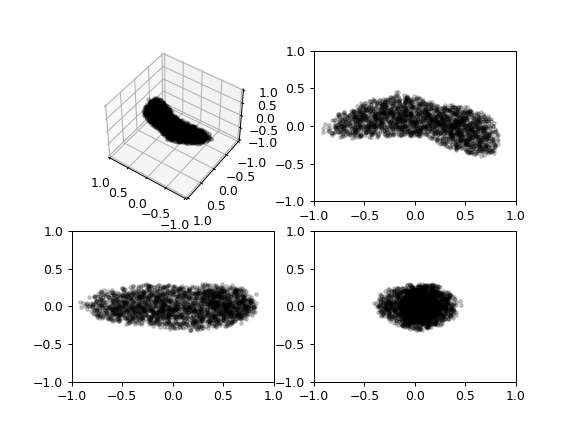

In [29]:
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=120000, crop_p=0.2, s=30)


#### Saving the model

In [30]:
# Uncomment to save to models/cluster_xxxx
torch.save(model.state_dict(), "models/" + name + "_" + encoding.name + ".mdl")

# TODO list:

* Code efficiency -> move to GPU and make training scalable to more sample points / mc points.
* MC integration -> importance sampling maybe?
* Network architecture -> study different encodings
* How to visualize and interpret the results quantitatively.
* Propagate trajectories around the asteroids (ground truth and trained).
* Incorporate visual cues.
* Training with gravity rather than potential?
* What happens for non uniform bodies?